# Spatial Interpolation

Spatial interpolation is used to predicts values for cells in a raster from a limited number of sample data points around it. We are studying streaming high frequency temperature data in Chicago retrieved from Array of Thing [(AoT)](https://api.arrayofthings.org/). 

### Retrieve the study area of this interactive spatial interpolation jupyter notebook

                                            geometry  \
0  POLYGON ((-87.94010 42.00093, -87.94003 41.998...   

                                          place_name  bbox_north  bbox_south  \
0  Chicago, Cook County, Illinois, United States ...    42.02304   41.644531   

   bbox_east  bbox_west  
0 -87.524081 -87.940101  


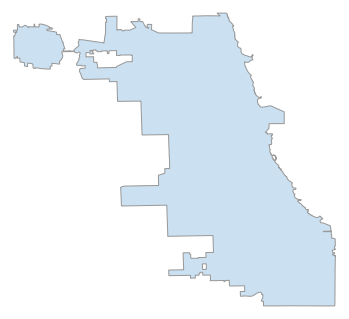

In [2]:
#!pip install pykrige
import osmnx as ox
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__
# from some place name, create a GeoDataFrame containing the geometry of the place
city = ox.gdf_from_place('Chicago, IL')
print (city)
# save the retrieved data as a shapefile
ox.save_gdf_shapefile(city)
# project the geometry to the appropriate UTM zone (calculated automatically) then plot it
#city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city)

In [3]:
# save the retrieved and projected data as a shapefile
ox.save_gdf_shapefile(city)

In [4]:

import numpy as np
import pandas as pd
import glob
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
import pykrige.kriging_tools as kt
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Path, PathPatch

### Show the points available in Chicago with accurate data

In [5]:
import numpy as np
import pandas as pd

# uncomment to get from CSV
data = pd.read_csv(
     'sensors.csv',
     delim_whitespace=False, header=None,
     names=["ID","Lat", "Lon", "Z"])
#data = pd.DataFrame(dd)
data.head(len(data))

,ID,Lat,Lon,Z
0,001e0610ba46,41.878377,-87.627678,28.24
1,001e0610ba13,41.751238,-87.712990,19.83
2,001e0610bc10,41.736314,-87.624179,26.17
3,001e0610ba15,41.722457,-87.575350,45.70
4,001e0610bbe5,41.736495,-87.614529,35.07
5,001e0610ee36,41.751295,-87.605288,36.47
6,001e0610ee5d,41.923996,-87.761072,22.45
7,001e06113ad8,41.866786,-87.666306,125.01
8,001e0611441e,41.808594,-87.665048,19.82
9,001e06112e77,41.786756,-87.664343,26.21


In [6]:
lons=np.array(data['Lon']) 
lats=np.array(data['Lat']) 
zdata=np.array(data['Z'])
print (zdata)

#If some data are greate than 50, then 
for r in range(len(zdata)):
    if zdata[r]>50:
        zdata[r] = 45

print (zdata)

[ 28.24  19.83  26.17  45.7   35.07  36.47  22.45 125.01  19.82  26.21
  22.04  20.2   20.5   42.15  21.67  25.14 125.01  21.16  19.5   21.61
  32.03  28.3   20.11  40.6   42.8   31.46  21.35  21.99  21.62  20.88
  20.55  20.41]
[28.24 19.83 26.17 45.7  35.07 36.47 22.45 45.   19.82 26.21 22.04 20.2
 20.5  42.15 21.67 25.14 45.   21.16 19.5  21.61 32.03 28.3  20.11 40.6
 42.8  31.46 21.35 21.99 21.62 20.88 20.55 20.41]


### Use ordinary kriging to do the spatial interpolation

In [7]:
import geopandas as gpd
Chicago_Boundary_Shapefile = './data/il-chicago/il-chicago.shp'
boundary = gpd.read_file(Chicago_Boundary_Shapefile)
# Plots the boundary of Chicago 

xmin, ymin, xmax, ymax = boundary.total_bounds

xmin = xmin-0.01
xmax = xmax+0.01

ymin = ymin-0.01
ymax = ymax+0.01

grid_lon = np.linspace(xmin, xmax, 100)
grid_lat = np.linspace(ymin, ymax, 100)

In [8]:
OK = OrdinaryKriging(lons, lats, zdata, variogram_model='gaussian', verbose=True, enable_plotting=False,nlags=20)
z1, ss1 = OK.execute('grid', grid_lon, grid_lat)
print (z1)

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 23.13242836937993
Full Sill: 93.76725570798001
Range: 0.3088207463280863
Nugget: 70.63482733860009 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

[[27.929638433137395 27.88580399705175 27.84021911748495 ...
  31.38644356399663 31.404556267770424 31.415938741488706]
 [27.905896385139297 27.86068318906147 27.813668950161066 ...
  31.44165040499309 31.460519582840643 31.472493748359742]
 [27.882112189386508 27.835521908251977 27.787080234206595 ...
  31.494390481874742 31.514039150198585 31.526631381203416]
 ...
 [29.130760923267943 29.155208360026478 29.18011516997045 ...
  29.049409504791075 29.041974883402517 29.034401750480814]
 [29.13587057789517 29.160612631119093 29.18582733321045 ...
  29.039409247481995 29.031638689148526 29.023773683305016]
 [29.139753070653423 29.164724932521015 29.19018090528701 ...
 

In [9]:
OK = OrdinaryKriging(lons, lats, zdata, variogram_model='linear', verbose=True, enable_plotting=False,nlags=20)
z2, ss1 = OK.execute('grid', grid_lon, grid_lat)
#print (z2)

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 78.08683547092697
Nugget: 69.86456553372653 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [10]:
#print (z1)

import matplotlib.path as mpath
import matplotlib.patches as mpatches
import shapefile as shp

Path = mpath.Path

#read shape file
sfile = shp.Reader('./data/il-chicago/il-chicago.shp')

#fig = plt.figure(figsize=(30,30))
#ax = fig.add_subplot(1,1,1)

#fig, ax = plt.subplots(figsize=(30,30))

#make clip path
for shape_rec in sfile.shapeRecords():
    verticess = []
    codes = []
    pts = shape_rec.shape.points
    prt = list(shape_rec.shape.parts) + [len(pts)]
    for i in range(len(prt) - 1):
        for j in range(prt[i], prt[i+1]):
            verticess.append((pts[j][0], pts[j][1]))
        codes += [Path.MOVETO]
        codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
        codes += [Path.CLOSEPOLY]
    clip = mpath.Path(verticess, codes)
    clip = mpatches.PathPatch(clip, facecolor = 'white')#white

#plot    
#ax.add_patch(clip)
print ((clip))

PathPatch4112((-87.9401, 42.0009) ...)


### Plot the spatial interpolation result

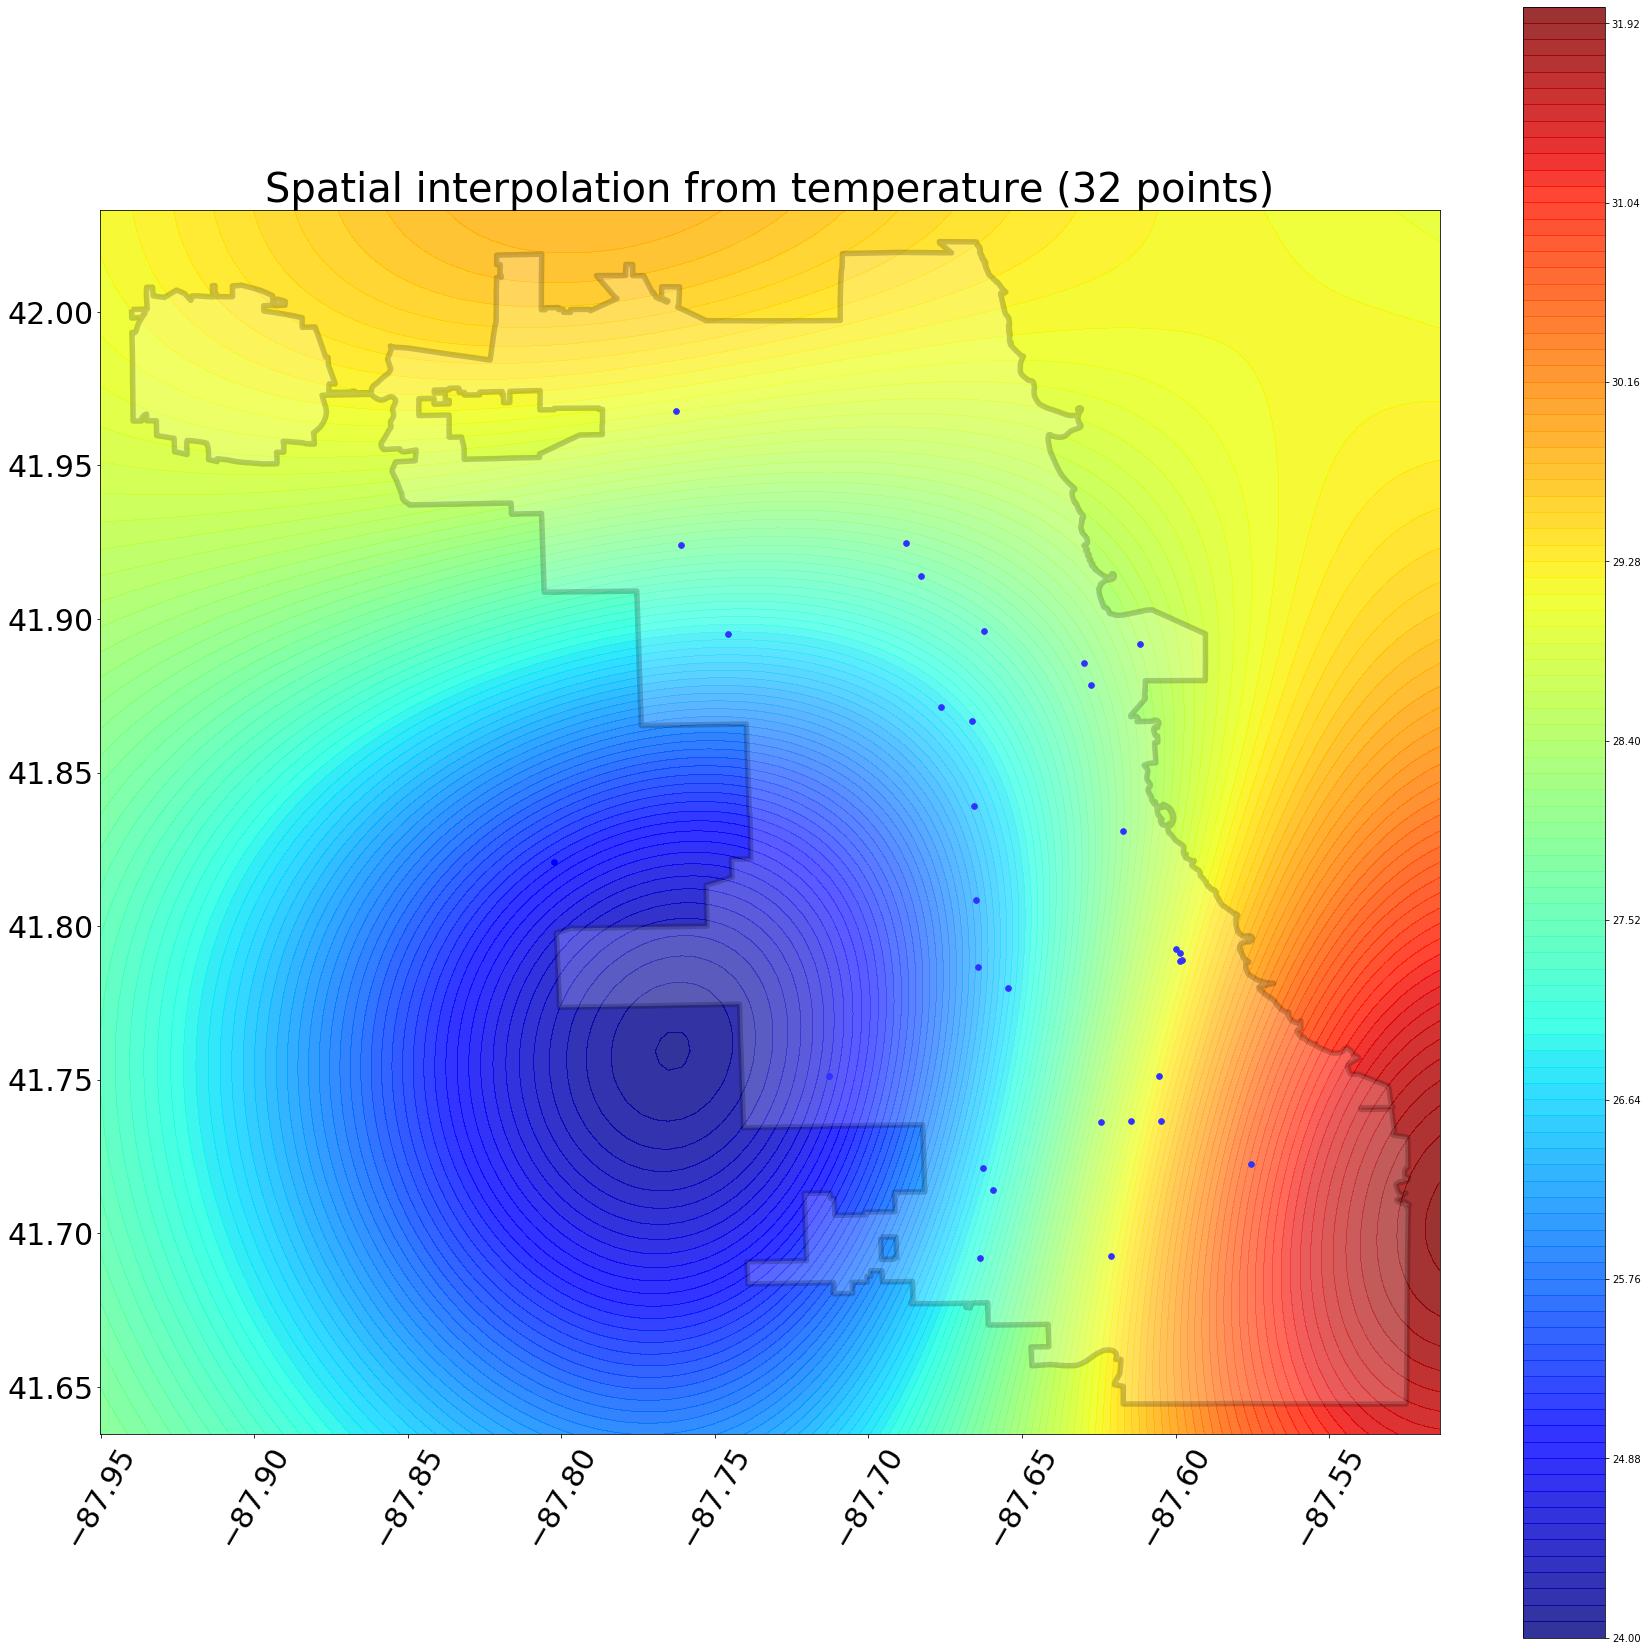

In [11]:
xintrp, yintrp = np.meshgrid(grid_lon, grid_lat) 
fig, ax = plt.subplots(figsize=(30,30))


#ax.scatter(lons, lats, s=len(lons), label='Input data')
boundarygeom = boundary.geometry

contour = plt.contourf(xintrp, yintrp, z1,len(z1),cmap=plt.cm.jet,alpha = 0.8) 
#contour = ax.contourf(xintrp, yintrp, z1, cmap="jet", alpha=0.8)
plt.colorbar(contour)


boundary.plot(ax=ax, color='white', alpha = 0.2, linewidth=5.5, edgecolor='black', zorder = 5)
#boundary.plot(ax=ax, color='white', alpha = 0.4, linewidth=5.5, edgecolor='red', zorder = 5)



npts = len(lons)

plt.scatter(lons, lats,marker='o',c='b',s=npts)

#plt.xlim(xmin,xmax)
#plt.ylim(ymin,ymax)

plt.xticks(fontsize = 30, rotation=60)
plt.yticks(fontsize = 30)

#Tempreture
plt.title('Spatial interpolation from temperature (%d points)' % npts,fontsize = 40)
plt.show()
#ax.plot(grid_lon, grid_lat, label='Predicted values')
